# Lecture 20: ECT on Matisse

### Acknowledgements

 This notebook was written by [Liz Munch](https://elizabethmunch.com/) based on [original code](https://github.com/DanChitwood/matisse_test) from [Dan Chitwood](https://www.canr.msu.edu/people/dr_dan_chitwood) and modified from the [Python ECT tutorial](https://munchlab.github.io/ect/notebooks/Matisse/example_matisse.html).


## Matisse
 Here, we are going to give an example of using the ECT to classify the cutout shapes from Henri Matisse's 1952 ["The Parakeet and the Mermaid"](https://www.moma.org/audio/playlist/6/312).



 ![matisse.jpg](https://raw.githubusercontent.com/lizliz/CMSE890-TDA-Fall2025/refs/heads/main/JupyterFigures/matisse.jpg)

We are going to do this using the Python package [`ect`](https://munchlab.github.io/ect/index.html).

In [2]:
# pip install ect
# Uncomment if you haven't yet installed ect.

In [3]:
# -----------------
# Standard imports
# -----------------
import numpy as np  # for arrays
import matplotlib.pyplot as plt  # for plotting
from sklearn.decomposition import PCA  # for PCA for normalization
from scipy.spatial import distance_matrix

from os import listdir  # for retrieving files from directory
from os.path import isfile, join  # for retrieving files from directory
from sklearn.manifold import MDS  # for MDS
import pandas as pd  # for loading in colors csv
import os
import zipfile

import warnings
warnings.filterwarnings('ignore')

# ---------------------------
# The ECT packages we'll use
# ---------------------------
from ect import ECT, EmbeddedComplex  


 We've taken care of the preprocessing in advance by extracting out the shapes from the image.  


 <img src="https://raw.githubusercontent.com/lizliz/CMSE890-TDA-Fall2025/refs/heads/main/JupyterFigures/matisse_numbered.jpg" alt="Matisse Numbered" style="width:100%;">

### Get the data 



- The outlines of each leaf is here: [outlines.zip](https://github.com/lizliz/CMSE890-TDA-Fall2025/raw/main/JupyterFigures/matisse_outlines.zip). Extract the zip file to the same directory as this notebook. For the remainder, I will assume you have a folder now called `outlines` containing all of the data.
- A csv file containing the colors matching the colors from the cutouts is here: [matisse_colors.csv](https://raw.githubusercontent.com/lizliz/CMSE890-TDA-Fall2025/refs/heads/main/JupyterFigures/matisse_colors.csv). This isn't needed for the data analysis at all, just for nice visualization. Also make sure this is in the same path as your jupyter notebook. 

If all goes well, the following cell will check that everything is in the right place. 
 

In [4]:
# Simple data paths
data_dir = "outlines/"
colors_path = "matisse_colors.csv"

file_names = [
    f for f in listdir(data_dir) if isfile(join(data_dir, f)) and f[-4:] == ".txt"
]
file_names.sort()
print(f"There are {len(file_names)} files in the directory")

There are 150 files in the directory


### Look at the leaves 

<img src="https://raw.githubusercontent.com/lizliz/CMSE890-TDA-Fall2025/refs/heads/main/JupyterFigures/matisse_numbered.jpg" alt="Matisse Numbered" style="width:50%;">

Let's take a look at the leaf data. The following code loads in the leaf outline for the $i^{\text{th}}$ data point. Check to see that it matches up with the figure above. 

***Do this:*** Change $i$ to find some example of the colored "finger" leaves, some examples of the blue "apple" leaves, the parakeet, and the mermaid. 

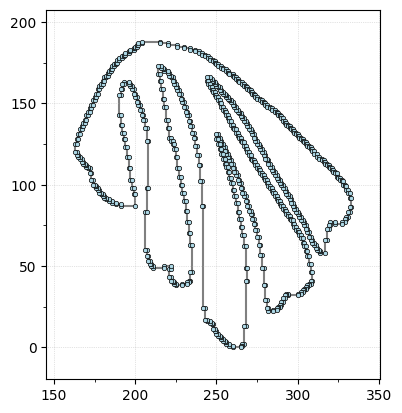

In [22]:
i = 10 # Pick a number between 1 and 150
shape = np.loadtxt(data_dir + file_names[i-1])
shape[:,1] = shape[:,1].max() - shape[:,1] # Flip y-axis for correct orientation
G = EmbeddedComplex()  # Using the unified EmbeddedComplex class
G.add_cycle(shape)
G.plot(with_labels=False, node_size=10);

 We're going to align the leaf using the PCA coordinates, min-max center, and scale it to fit in a ball of radius 1 for ease of comparisons.

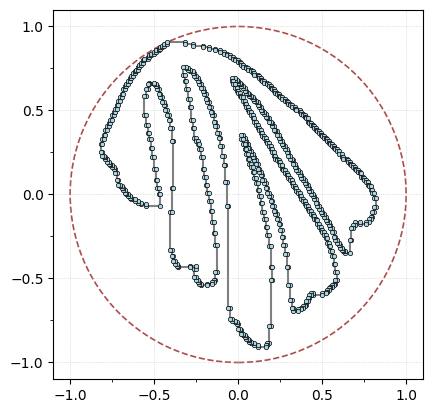

In [23]:
G.transform_coordinates(projection_type="pca")  # project with PCA
G.scale_coordinates(1)  # scale to radius 1
G.plot(with_labels=False, node_size=10, bounding_circle=True);

### Compute the ECT

In order to compute the (approximate) ECT we need to decide on two things: 

- The number of directions in $\mathbb{S}^1$ to use. 
- The number of threshold (AKA $a$ values) to use. 

With those two decisions, we can compute the ECT of this leaf as follows. 

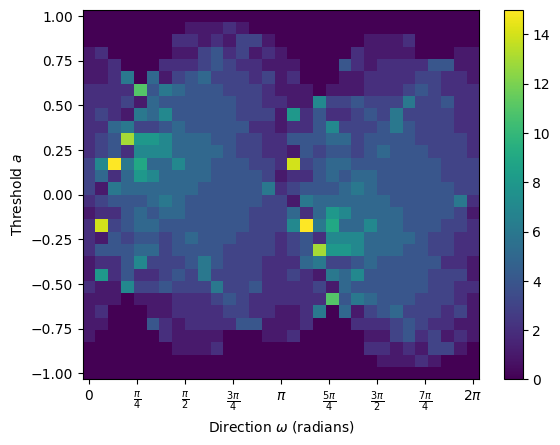

In [24]:
num_dirs = 30  # set number of directional axes
num_thresh = 30  # set number of thresholds each axis

myect = ECT(num_dirs=num_dirs, num_thresh=num_thresh);  # intiate ECT
result = myect.calculate(G);  # calculate ECT on embedded graph

result.plot();  # plot ECT

 Let's just make a data loader with all of this for ease in a bit.

In [25]:
def matisse_ect(i, ect):
    """
    Compute the ECT for the i-th Matisse leaf shape, where $i \in [1,150]$.
    
    """
    if i < 1 or i > 150:
        raise ValueError(f"i must be between 1 and 150, got {i}")
    filename = file_names[i-1] # Adjust for zero-based index
    shape = np.loadtxt(data_dir + filename)
    shape[:,1] = shape[:,1].max() - shape[:,1] # Flip y-axis for correct orientation
    G = EmbeddedComplex()  # Using the unified EmbeddedComplex class  
    G.add_cycle(shape)
    G.transform_coordinates(projection_type="pca")
    G.scale_coordinates(1)
    result = ect.calculate(G)
    return G, result

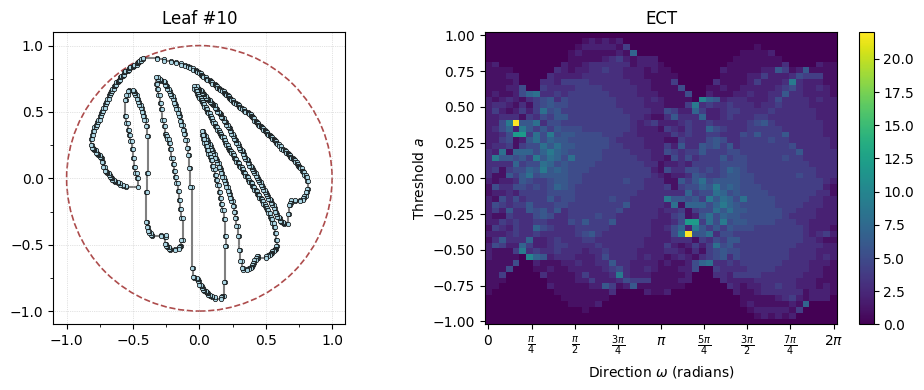

In [26]:
i = 10

# Actually compute the ECT for the ith leaf
myect = ECT(num_dirs=50, num_thresh=50)
G, result = matisse_ect(i, myect) #<- This is the data loader we just defined

# The rest is plotting
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

# Plot the ith fern leaf on the left
G.plot(ax=axes[0], with_labels=False, node_size=10, bounding_circle=True)
axes[0].set_title(f"Leaf #{i}")

# Plot the ECT on the right
result.plot(ax=axes[1])
axes[1].set_title("ECT")

plt.tight_layout();

***Do this:*** What do you notice changes about the ECT, particularly for the "finger" leaves vs the "apple" leaves.

## Comparing ECTs

<img src="https://raw.githubusercontent.com/lizliz/CMSE890-TDA-Fall2025/refs/heads/main/JupyterFigures/matisse_numbered.jpg" alt="Matisse Numbered" style="width:50%;">

We can use the $L_2$ distance between matrices to compare two of these leaves. 

In [27]:
finger_i = 3 # Choos a leaf index, in this case the top left pink finger leaf 
apple_i = 57 # Choose a leaf index, in this case the blue apple leaf at the top left 

num_dirs = 60  # set number of directional axes
num_thresh = 50  # set number of thresholds each axis
myect = ECT(num_dirs=num_dirs, num_thresh=num_thresh, bound_radius=1)
G_finger,fingerECT = matisse_ect(finger_i, myect)
G_apple,appleECT = matisse_ect(apple_i, myect)


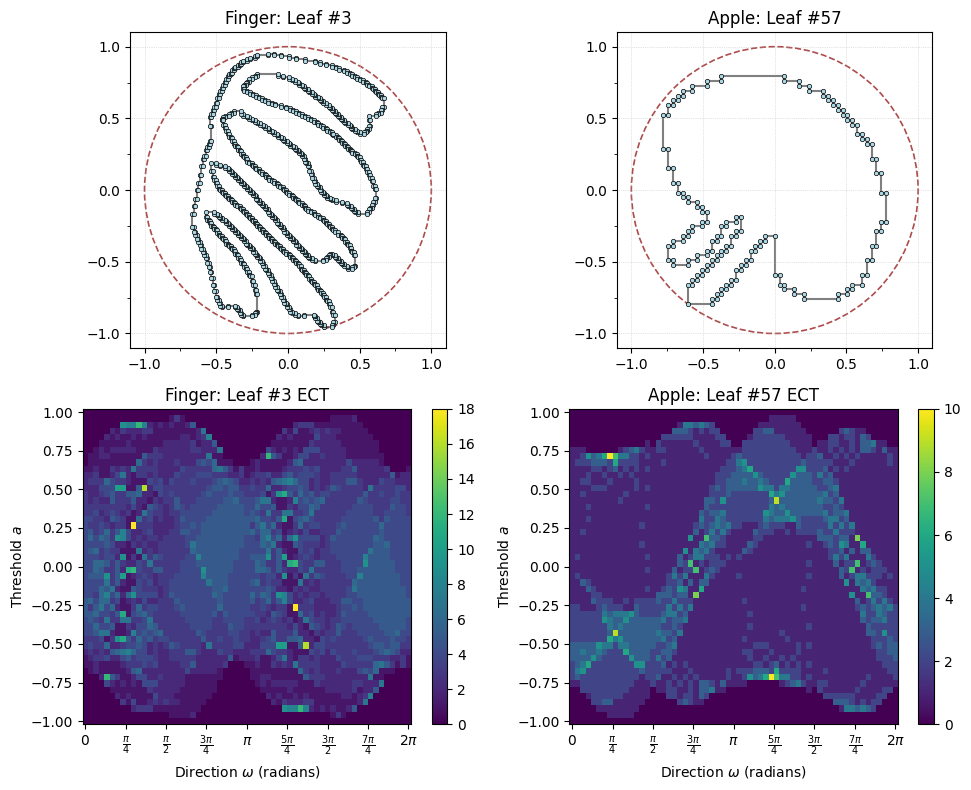

In [28]:
# Plot the finger and apple graphs above their ECTs
fig, axes = plt.subplots(2, 2, figsize=(10, 8))

# Top row: graphs
G_finger.plot(ax=axes[0,0], with_labels=False, node_size=10, bounding_circle=True)
axes[0,0].set_title(f"Finger: Leaf #{finger_i}")

G_apple.plot(ax=axes[0,1], with_labels=False, node_size=10, bounding_circle=True)
axes[0,1].set_title(f"Apple: Leaf #{apple_i}")

# Bottom row: ECTs
fingerECT.plot(ax=axes[1,0])
axes[1,0].set_title(f"Finger: Leaf #{finger_i} ECT")

appleECT.plot(ax=axes[1,1])
axes[1,1].set_title(f"Apple: Leaf #{apple_i} ECT")

plt.tight_layout();

To get a distance between the two ECTs, we can compute the distance using standard $L_2$ distance between matrices. That is 

$$
\|M_1-M_2\| = \left( \sum_{i,j} \big|M_1[i,j] - M_2[i,j]\big|^2 \right) ^{1/2}
$$

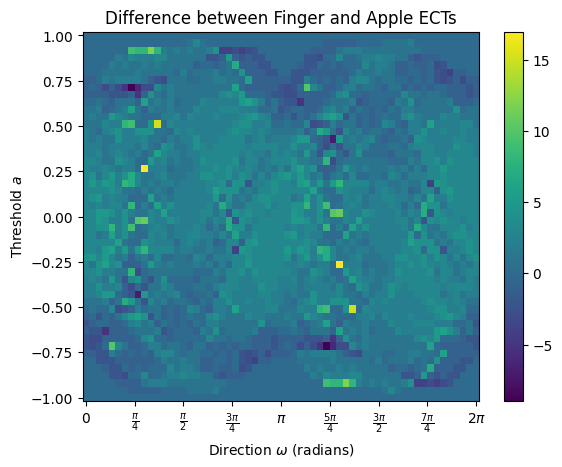

In [29]:
# Here's the difference matrix
diff = fingerECT-appleECT

diff.plot()
plt.title("Difference between Finger and Apple ECTs");

In [30]:
# We can get the actual distance by computing the L2 norm of the difference matrix
np.sqrt(sum(sum(diff**2)))

np.float64(135.68345514468592)

That number doesn't mean much to me without seeing it in the context of distances between other choices. So, let's look at all the distances at once. 

In this cell, we load in all the outlines, compute their ECT, and store it in a 3D array.

In [31]:
num_dirs = 60  # set number of directional axes
num_thresh = 50  # set number of thresholds each axis

ect_arr = np.zeros((len(file_names), num_dirs, num_thresh))
myect = ECT(num_dirs=num_dirs, num_thresh=num_thresh, bound_radius=1)

for i in range(150):  # for each leaf
    _, ect_arr[i, :, :] = matisse_ect(i+1, myect)

ect_arr.shape  # (num_shapes, num_directions, num_thresholds)   

(150, 60, 50)

The next cell computes the distance between all pairs of ECTs using $L_2$ distance.

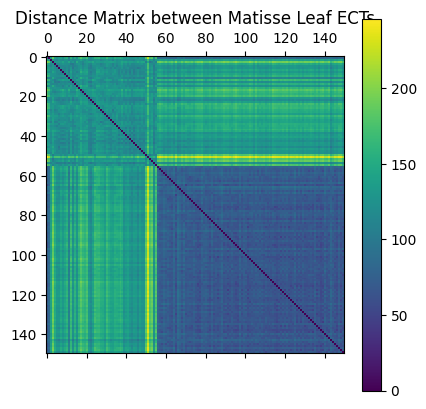

In [32]:
flattened_ect = ect_arr.reshape(len(file_names), num_dirs * num_thresh)
D = distance_matrix(flattened_ect, flattened_ect)
plt.matshow(D)
plt.colorbar()
plt.title("Distance Matrix between Matisse Leaf ECTs");


 **Questions:** 
 - What does entry $D[i,j]$ mean? 
 - Why is there a dark blue (lower value) square in the bottom right? 

 For visualization purposes, we can project this data into 2D using [Multi Dimensional Scaling (MDS)](https://en.wikipedia.org/wiki/Multidimensional_scaling). 

In [33]:
n_components = 2  # select number of components
mds = MDS(
    n_components=n_components,  # initialize MDS
    dissimilarity="precomputed",  # we have precomputed the distance matrix
    normalized_stress="auto",
    random_state=5,  # select random state for reproducibility
)
MDS_scores = mds.fit_transform(D)  # get MDS scores


Here we plot each figure at the MDS coordinates.

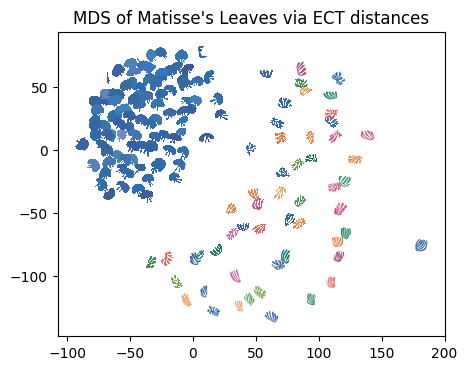

In [34]:
# read in color hexcodes. Again, this has nothing to do with the analysis!
col_df = pd.read_csv(colors_path, header=None)

scale_val = 6  # set scale value
plt.figure(figsize=(5, 5))  # set figure dimensions

for i in range(len(file_names)):  # for each leaf
    shape = np.loadtxt(data_dir + file_names[i])  # get the current shape
    shape = shape - np.mean(shape, axis=0)  # zero center shape
    shape = (
        scale_val * shape / max(np.linalg.norm(shape, axis=1))
    )  # scale to radius 1 then mult by scale_val

    trans_sh = shape + MDS_scores[i]  # translate shape to MDS position

    plt.fill(trans_sh[:, 0], trans_sh[:, 1], c=col_df[0][i], lw=0)  # plot shape
    plt.gca().set_aspect("equal")

plt.title("MDS of Matisse's Leaves via ECT distances");

***Questions:***

- What do you notice about the placement of the leaves? 
- Where did the parakeet and mermaid end up? 
- What do you notice about the density of the apple leaves vs. the finger leaves? Why do you think this is? 